# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**

## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

## Importing all libraries

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import plotly.express as px
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

### Getting to know the data

In [232]:
df=pd.read_csv("recipe_site_traffic_2212.csv")
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [195]:
df.shape

(947, 8)

 947 samples and 8 features (columns)

In [196]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


Servings column should be numeric. We will fix that later

In [198]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
recipe,947.0,474.000000,273.519652,1.00,237.500,474.00,710.500,947.00
calories,895.0,435.939196,453.020997,0.14,110.430,288.55,597.650,3633.16
carbohydrate,895.0,35.069676,43.949032,0.03,8.375,21.48,44.965,530.42
sugar,895.0,9.046547,14.679176,0.01,1.690,4.55,9.800,148.75
protein,895.0,24.149296,36.369739,0.00,3.195,10.80,30.200,363.36


# Data Validation

### No duplicates

In [199]:
df.duplicated().sum()

0

## Servings column

#### We need to change the type of the column to integer

In [200]:
df["num_servings"]=df['servings'].str.extract("(\d+)")
df.num_servings

0      6
1      4
2      1
3      4
4      4
      ..
942    2
943    2
944    2
945    6
946    4
Name: num_servings, Length: 947, dtype: object

extracted the numbers from the object column

In [201]:
df.num_servings=df.num_servings.astype('int')
df.num_servings.value_counts()

4    391
6    198
2    183
1    175
Name: num_servings, dtype: int64

### the only possible values are 1, 2, 4, and 6 servings

## Dealing with Null values in the rest of Numerical Features

In [202]:
df.isnull().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
num_servings      0
dtype: int64

 We can see that most numerical columns have the same number of null values. This can mean that they are on the same rows or not, so we should check this when validating.

373 null values on high_traffic (target variable) are a great deal of null values on a very important column which may cause issues onward.

In [203]:
df.isnull().mean()*100

recipe           0.000000
calories         5.491024
carbohydrate     5.491024
sugar            5.491024
protein          5.491024
category         0.000000
servings         0.000000
high_traffic    39.387540
num_servings     0.000000
dtype: float64

### They represent more than 5 percent

In [204]:
len(df[(df.calories.isnull()) & (df.carbohydrate.isnull()) & (df.sugar.isnull()) & (df.protein.isnull())])

52

#### All the numerical null values are found in the same 52 rows

#### We fill by the median of the same category

In [205]:
columns_to_fill=['calories', 'carbohydrate', 'sugar', 'protein']
for column in columns_to_fill: 
    df[column]=df.groupby(["category",'num_servings'])[column].apply(lambda group: group.fillna(group.median()))
df.isnull().sum()

recipe            0
calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    373
num_servings      0
dtype: int64

##### We will deal with high traffic later on after dealing with other problems in numerical data

## Categorical Columns

#### We have two categorical columns: category and high_traffic.
#### We will transform them to categorical

## Category column

#### Category column is considered nominal

In [206]:
df.category.value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

### Chicken and Chicken Breast should be the same

In [207]:
df['category'] = df['category'].str.replace('Chicken Breast','Chicken')

In [208]:
df['category']=df['category'].astype('category')
df.category.dtype

CategoricalDtype(categories=['Beverages', 'Breakfast', 'Chicken', 'Dessert',
                  'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato',
                  'Vegetable'],
, ordered=False)

## High_traffic column

In [209]:
df.high_traffic.value_counts(dropna=False)

High    574
NaN     373
Name: high_traffic, dtype: int64

We can assume that the null values can only be the samples with low traffic

In [210]:
df.high_traffic.fillna("Low",inplace=True)
df.high_traffic.value_counts(dropna=False)

High    574
Low     373
Name: high_traffic, dtype: int64

#### High_traffic column is considered ordinal

In [211]:
df['high_traffic']=pd.Categorical(df['high_traffic'],ordered=True,categories=["Low","High"])
df.high_traffic.dtype

CategoricalDtype(categories=['Low', 'High'], ordered=True)

# EDA

### Distribution of categorical data

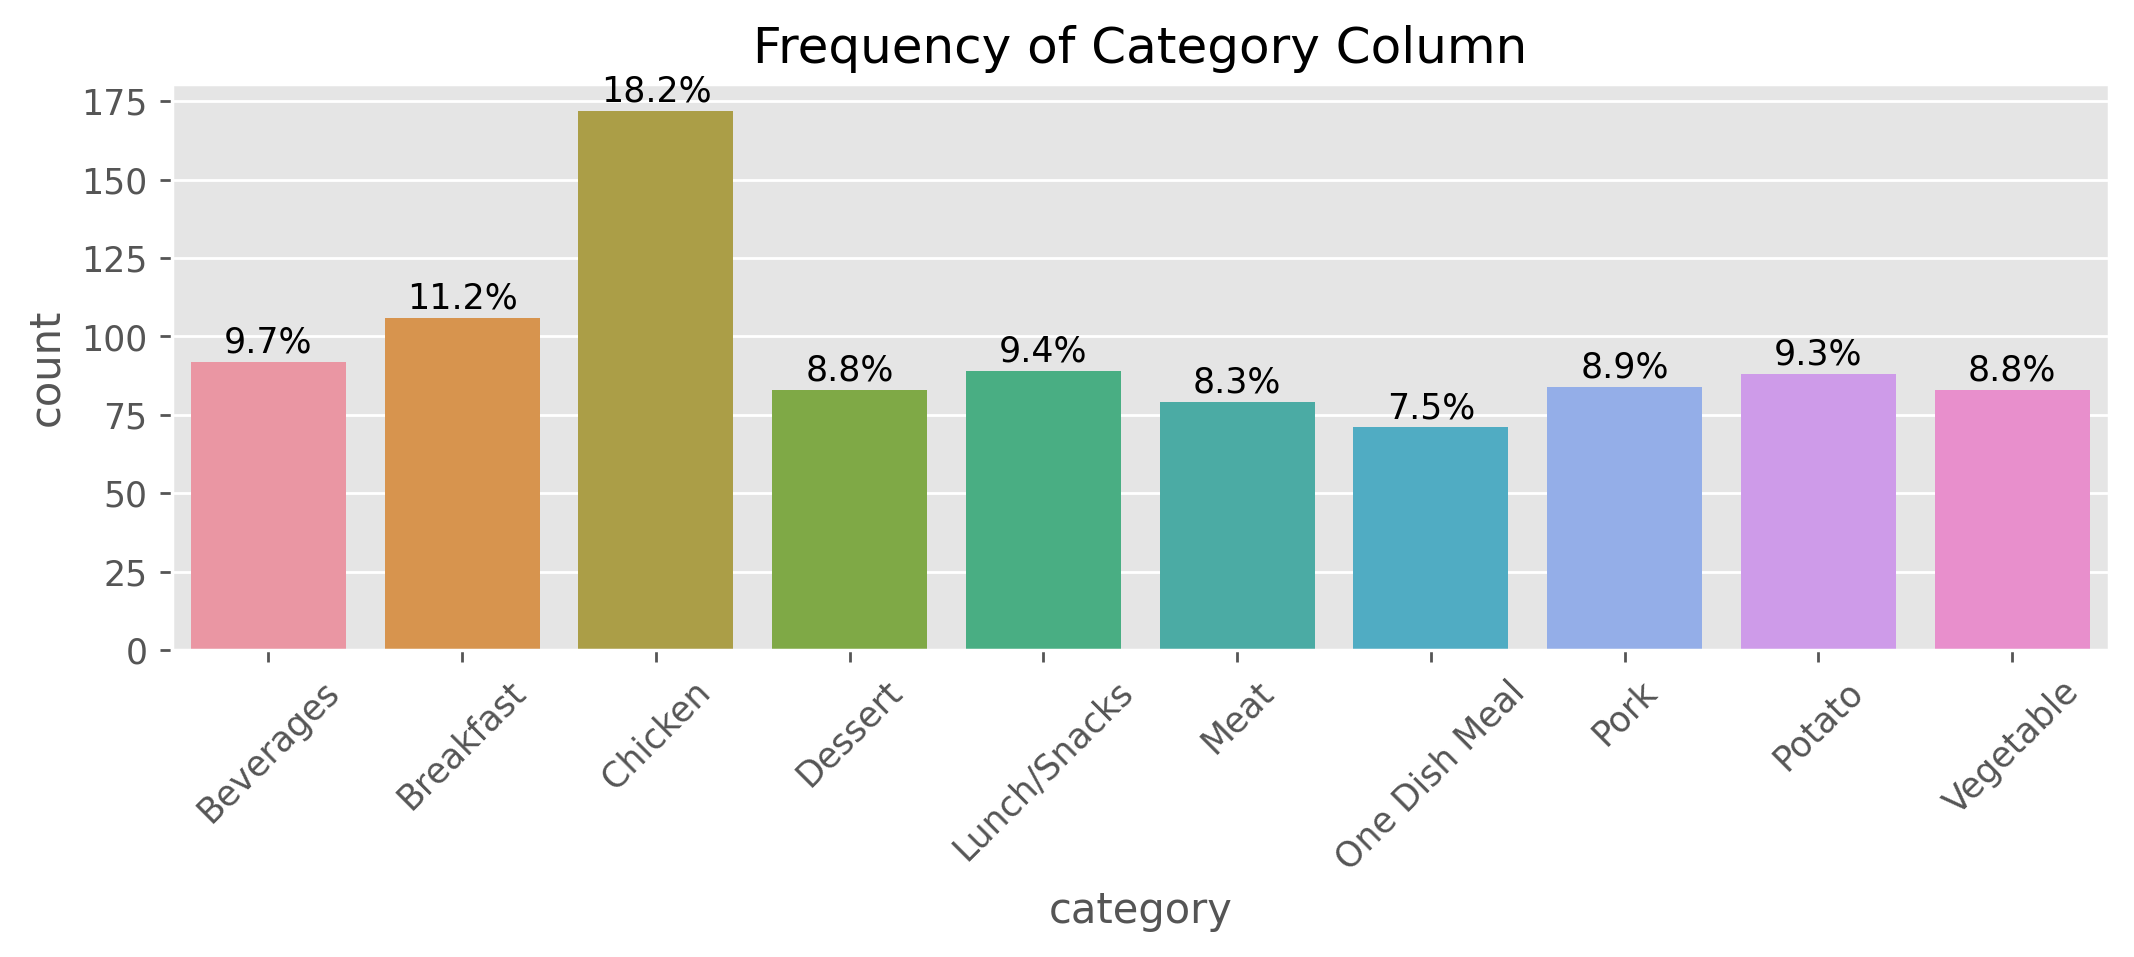

In [212]:
style.use('ggplot')
fig, ax =plt.subplots(figsize=(10,3), 
           dpi = 250) 
ax=sns.countplot(data=df,x="category",ax=ax)
plt.xticks(rotation=45,fontsize=10)
plt.yticks(fontsize=10)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{0:.1%}'.format(height/len(df)), ha="center")
plt.title("Frequency of Category Column")
plt.show()


#### Category column is almost normally distributed

In [213]:
px.pie( values=df.high_traffic.value_counts(), names=df.high_traffic.value_counts().index, title='High Traffic Frequency')


#### Data is biased towards High traffic.

Text(0.5, 1.0, 'Frequency of Traffic in Each Category')

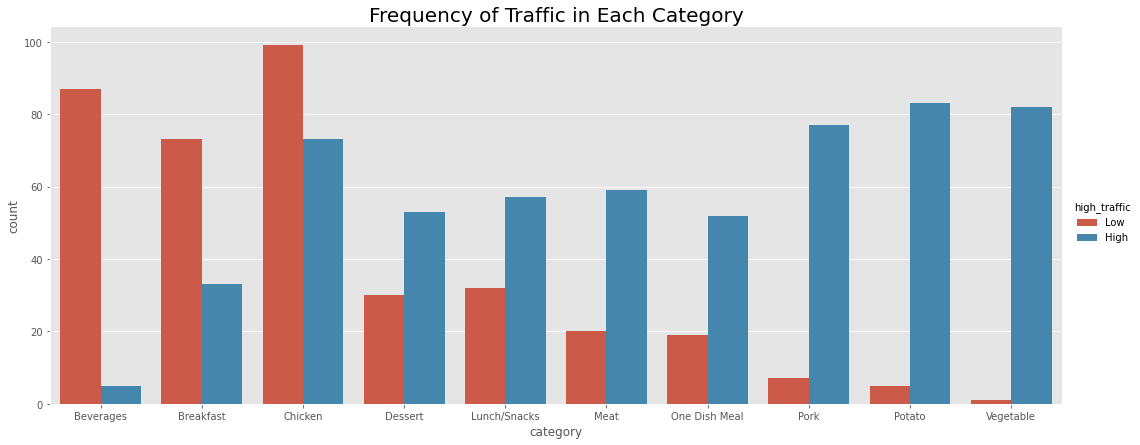

In [214]:
stacked = df.groupby(['category', 'high_traffic']).size().reset_index(name='count')
sns.catplot(x="category",y="count",data=stacked,hue="high_traffic",kind="bar",height=6,aspect=2.5)
plt.title("Frequency of Traffic in Each Category",fontsize=20)

### This graph shows us alot, almost all vegetables, potato, and pork did get high traffic while beverages was low most of the times.
Additionally, Meat and One Dish Meal categories can also have a lot of potential if used often.

### Distribution of numerical data

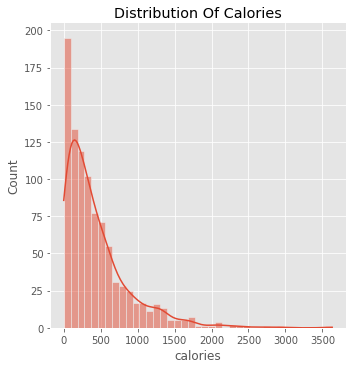

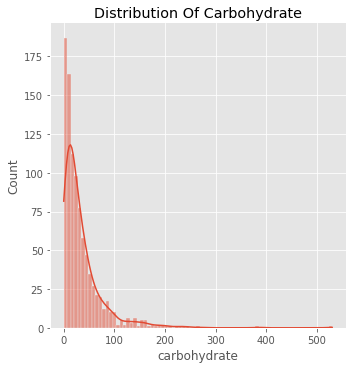

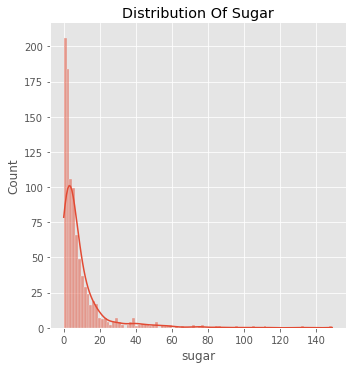

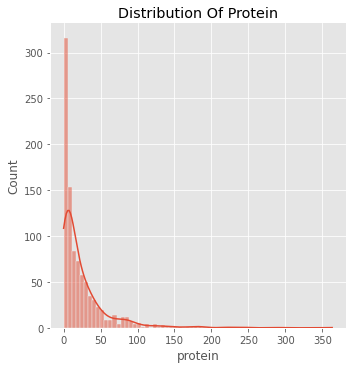

In [215]:
# style.use('seaborn-v0_8-deep')
numerical=["calories","carbohydrate","sugar","protein"]
for column in numerical:
    sns.displot(data=df,x=column,kde=True)
    plt.title(f"Distribution of {column}".title())

#### All numerical data are basically highly right skewed.

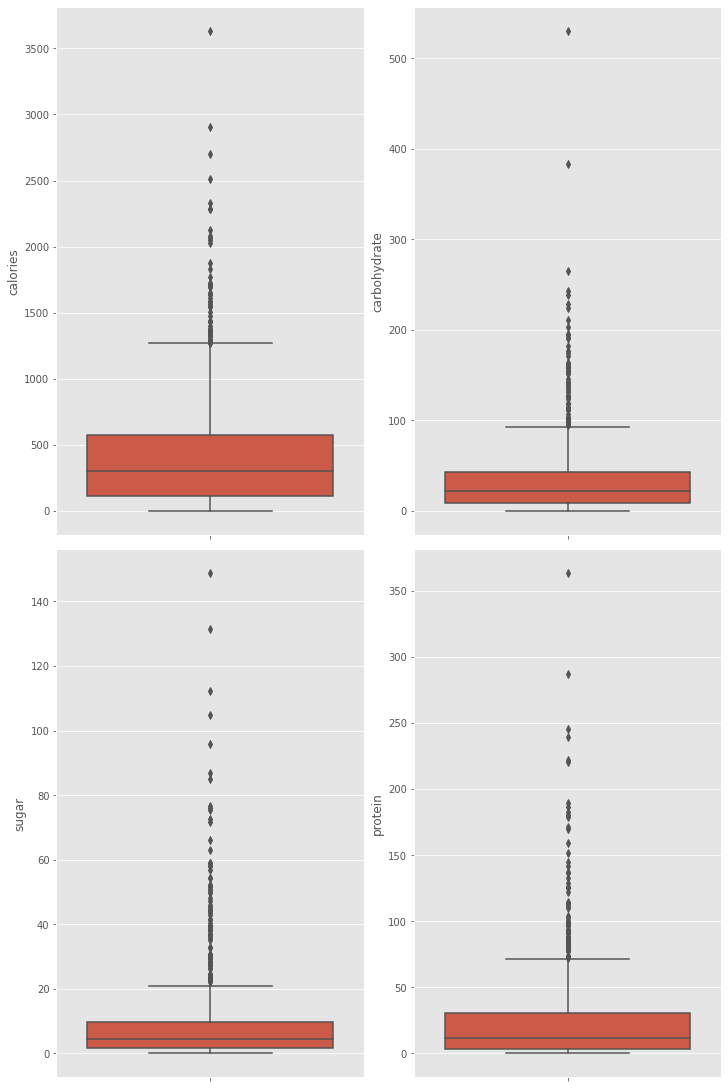

In [216]:
figure, (axis) = plt.subplots(2,2 ,figsize=(10,15),constrained_layout = True,)
for column,ax in zip(numerical,axis.ravel()):
    sns.boxplot(data=df,y=column,ax=ax)

#### All of the numerical columns have a lot of outliers

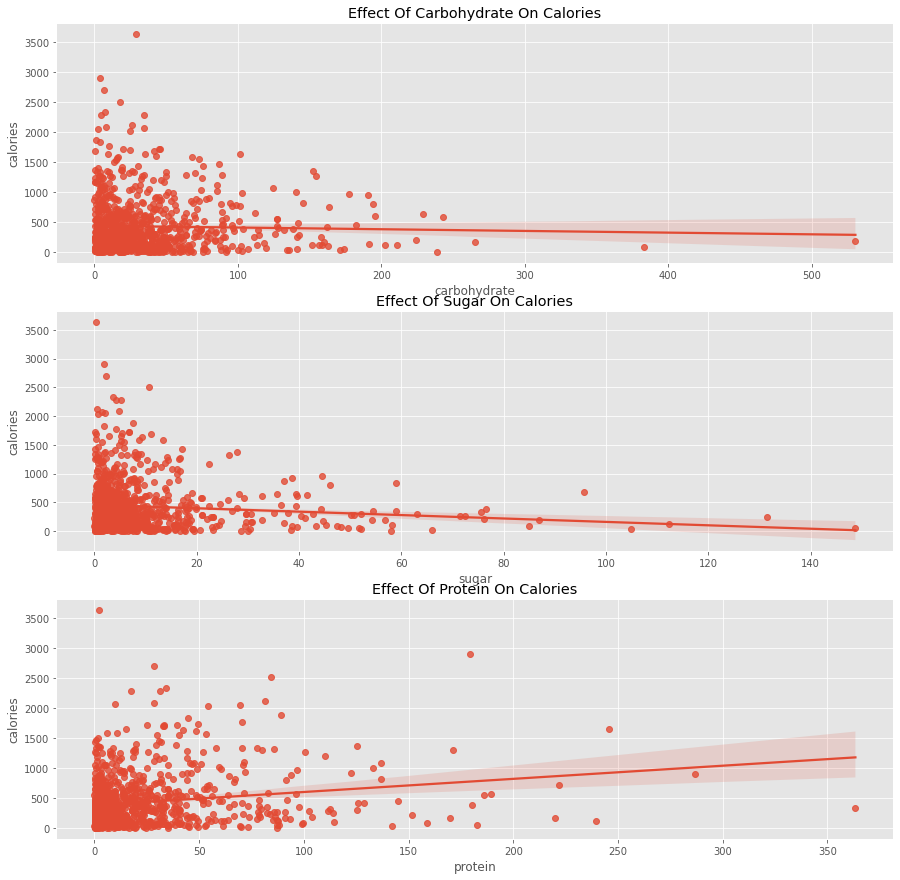

In [217]:
figure, (axis) = plt.subplots(3,1,figsize=(15,15))
for col,ax in zip(numerical[1:],axis.ravel()):
    ax=sns.regplot(data=df,x=col,y="calories",ax=ax)
    ax.set_title(f"Effect of {col} on calories".title())

### Correlation is very weak between calories and the rest of other numerical values

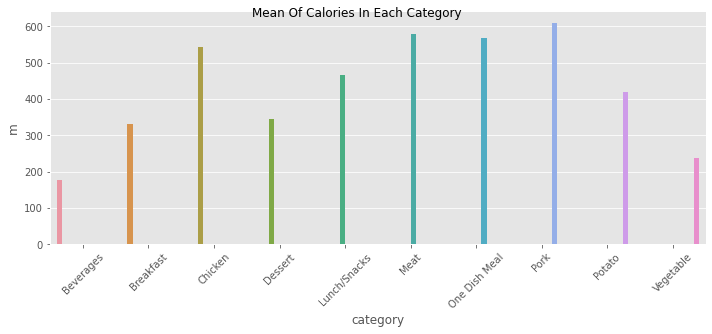

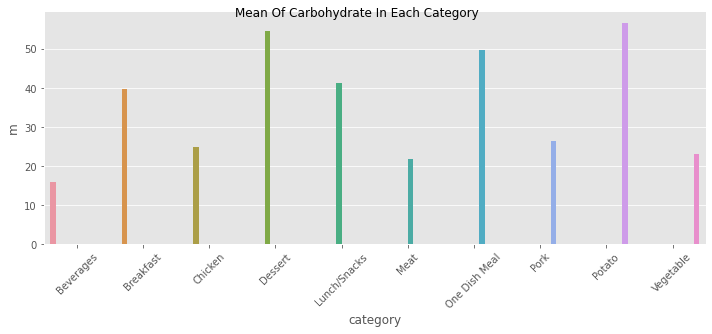

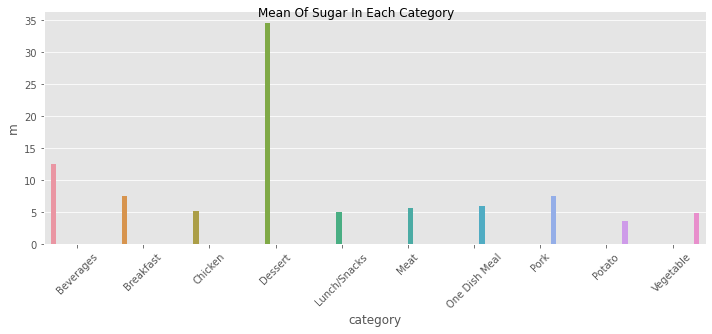

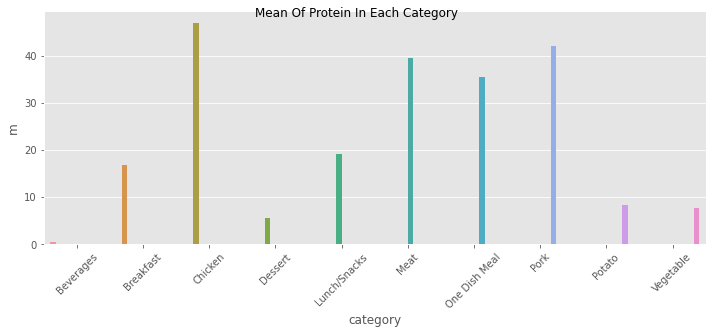

In [218]:
for col in numerical:
    stacked=df.groupby("category")[col].mean().reset_index(name="m")
    ax=sns.catplot(data=stacked,x="category",y="m",hue="category",kind="bar",height=4, aspect=2.5)
    ax.fig.suptitle(f"Mean of {col} in each category".title())
    plt.xticks(rotation=45)
    

### There is no any correlation between the presence of calories, proteins, sugars, and carbohydrates in a category and getting high or low traffic in this category.

<AxesSubplot:>

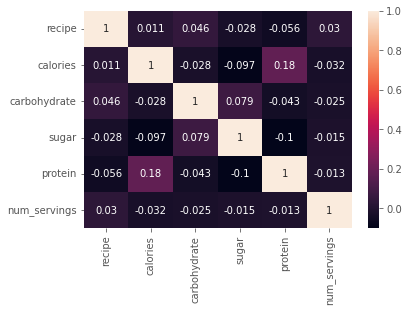

In [219]:
sns.heatmap(df.corr(),annot=True)

#### No linear correlation between features

In [220]:
grouped=df.groupby(["category"])["high_traffic"].value_counts(normalize=True)
grouped


category           
Beverages      Low     0.945652
               High    0.054348
Breakfast      Low     0.688679
               High    0.311321
Chicken        Low     0.575581
               High    0.424419
Dessert        High    0.638554
               Low     0.361446
Lunch/Snacks   High    0.640449
               Low     0.359551
Meat           High    0.746835
               Low     0.253165
One Dish Meal  High    0.732394
               Low     0.267606
Pork           High    0.916667
               Low     0.083333
Potato         High    0.943182
               Low     0.056818
Vegetable      High    0.987952
               Low     0.012048
Name: high_traffic, dtype: float64

# Model Development

## Preprocessing 

### We are going to encode Category column
### We are going to remove irrelevant columns
### Due to having varying variances in each feature, we are going to use Standard Scaler on numerical data


#### One Hot Encoding

In [221]:
# df = pd.get_dummies(df,columns=['category'])
# df["high_traffic"]=np.where(df["high_traffic"]=="High",1,0)
# df.columns

#### Removing columns irrelevent columns

In [222]:
df.drop(["servings",'recipe'],axis=1,inplace=True)
df.columns

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'high_traffic', 'num_servings'],
      dtype='object')

## Model Selection

### This business problem is a supervised learning classification problem
### The models I am going to try are Logistic Regression, SVC,and Random Forest.
### Then I am going to compare the best of these models with Gradient Boosting and Adaboost

In [223]:
df["high_traffic"]=np.where(df["high_traffic"]=="High",1,0)
X=df.drop(["high_traffic"],axis=1)
y=df["high_traffic"]
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y)


processor=Pipeline([('preprocessor', ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(), ['category']),
            ('numeric', StandardScaler(), ['calories','carbohydrate','sugar','protein']),
        ],
        remainder='passthrough'
    ))])


In [224]:
X_train_processed=processor.fit_transform(X_train)
X_test_processed=processor.transform(X_test)

X_train_processed,y_train_processed=SMOTE(random_state=3).fit_resample(X_train_processed,y_train)

In [242]:
X_train.columns

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'num_servings'],
      dtype='object')

In [240]:
X_train.iloc[0].values

array([113.37, 4.9, 1.29, 17.08, 'Pork', 6], dtype=object)

In [225]:

models=[LogisticRegression(),LinearDiscriminantAnalysis(),RidgeClassifier()]
for model in models:
    model.fit(X_train_processed, y_train_processed)
    print("Training Accuracy: %0.2f" % (model.score(X_train_processed, y_train_processed)))
    print("Testing Accuracy: %0.2f" % (model.score(X_test_processed, y_test)))
    print("-----------------------------------------------------------------")

Training Accuracy: 0.77
Testing Accuracy: 0.76
-----------------------------------------------------------------
Training Accuracy: 0.76
Testing Accuracy: 0.76
-----------------------------------------------------------------
Training Accuracy: 0.76
Testing Accuracy: 0.76
-----------------------------------------------------------------


### GridSearching

In [226]:
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced']
}
grid_search=GridSearchCV(LogisticRegression(),param_grid=param_grid,scoring="accuracy")
grid_search.fit(X_train_processed,y_train_processed);
print("Best hyperparameters: ", grid_search.best_params_)
lr_best_model=grid_search.best_estimator_
print("Testing Accuracy: %0.2f" % lr_best_model.score(X_test_processed,y_test))

Best hyperparameters:  {'C': 1.0, 'class_weight': None, 'fit_intercept': True, 'max_iter': 100}
Testing Accuracy: 0.76


In [227]:
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

grid_search=GridSearchCV(RidgeClassifier(),param_grid=param_grid,scoring="accuracy")
grid_search.fit(X_train_processed,y_train_processed);
print("Best hyperparameters: ", grid_search.best_params_)
ridge_best_model=grid_search.best_estimator_
print("Testing Accuracy: %0.2f" % lr_best_model.score(X_test_processed,y_test))

Best hyperparameters:  {'alpha': 0.1, 'fit_intercept': False, 'solver': 'auto'}
Testing Accuracy: 0.76


In [228]:
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'tol': [1e-4, 1e-5],
    'store_covariance': [True, False]
}


grid_search=GridSearchCV(LinearDiscriminantAnalysis(),param_grid=param_grid,scoring="accuracy")
grid_search.fit(X_train_processed,y_train_processed);
print("Best hyperparameters: ", grid_search.best_params_)
lda_best_model=grid_search.best_estimator_
print("Testing Accuracy: %0.2f" % lr_best_model.score(X_test_processed,y_test))


Best hyperparameters:  {'solver': 'svd', 'store_covariance': True, 'tol': 0.0001}
Testing Accuracy: 0.76


c:\Users\karee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


12 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\karee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\karee\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\karee\AppData\Local\Programs\Python\Python310\lib\site-packag

### Gridsearching gave us the same accuracies so we will stick with the regular models

# Model Evaluation

### As the three models have the same accuracy, let's dive deeper and look at the confustion matrix of models' predictions.


In [229]:
for model in models:
    y_pred=model.predict(X_test_processed)
    print("Confusion Matrix\n",confusion_matrix(y_test, y_pred))
    print("Classification Report\n",classification_report(y_test, y_pred))
    print("-----------------------------------------------------------------")

Confusion Matrix
 [[ 71  22]
 [ 36 108]]
Classification Report
               precision    recall  f1-score   support

           0       0.66      0.76      0.71        93
           1       0.83      0.75      0.79       144

    accuracy                           0.76       237
   macro avg       0.75      0.76      0.75       237
weighted avg       0.77      0.76      0.76       237

-----------------------------------------------------------------
Confusion Matrix
 [[ 71  22]
 [ 36 108]]
Classification Report
               precision    recall  f1-score   support

           0       0.66      0.76      0.71        93
           1       0.83      0.75      0.79       144

    accuracy                           0.76       237
   macro avg       0.75      0.76      0.75       237
weighted avg       0.77      0.76      0.76       237

-----------------------------------------------------------------
Confusion Matrix
 [[ 71  22]
 [ 36 108]]
Classification Report
               precisio

In [230]:
X = pd.get_dummies(X, columns=['category'])
X.columns

Index(['calories', 'carbohydrate', 'sugar', 'protein', 'num_servings',
       'category_Beverages', 'category_Breakfast', 'category_Chicken',
       'category_Dessert', 'category_Lunch/Snacks', 'category_Meat',
       'category_One Dish Meal', 'category_Pork', 'category_Potato',
       'category_Vegetable'],
      dtype='object')

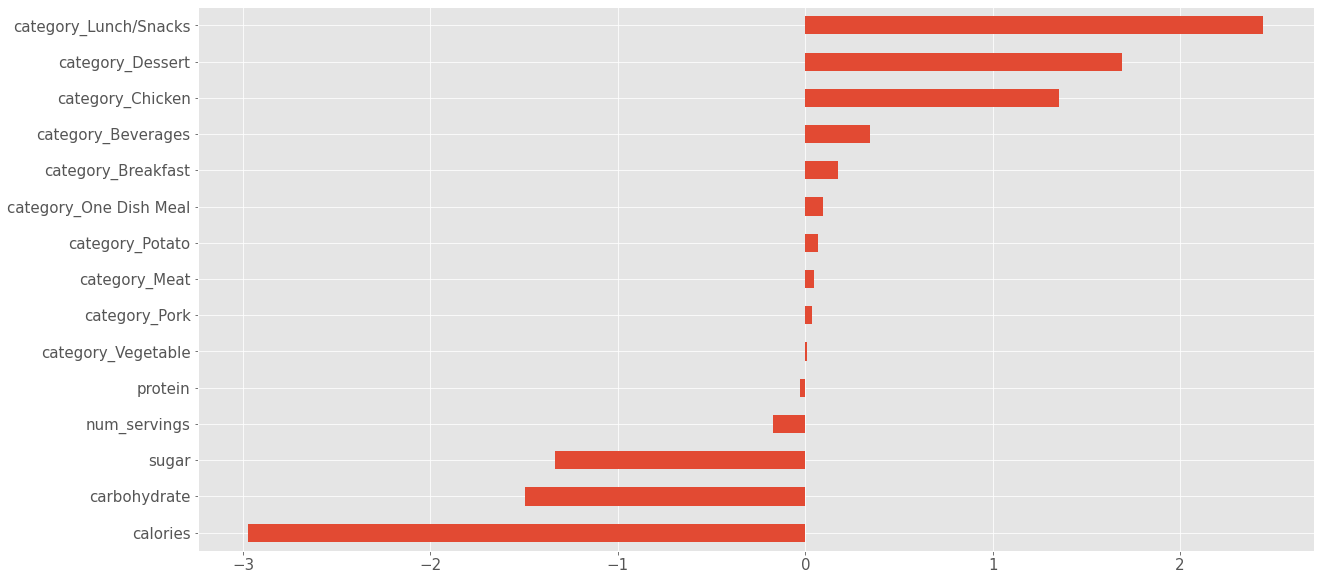

In [231]:
from matplotlib.pyplot import figure
plt.figure(figsize=(20,10))
feat_importances = pd.Series(models[0].coef_[0], index = X.columns).sort_values(ascending = True)
ax=feat_importances.plot(kind = 'barh')
ax.tick_params( which='both', labelsize=15)

### As stated when visualizing, numerical columns such as calories, carbs and the rest have no effect on traffic, while most of the effect comes from the category the recipe is in.

# Business Metrics

### Our model has a general accuracy 76% of predicting whether recipe will get high traffic or not. Additionally the model has 83% precision. To clarify, this means that the possibility of predicting a low traffic as high traffic is minimal.

# Summary

### My recommendation is:
### - Decrease chicken recipes and increase meat recipes.
### - Increase vegetables and potato recipes
### - Decrease beverage recipes